In [ ]:
!pip install --upgrade pip
!pip install --upgrade keras
!pip install -U -q tensorflow
#!pip show keras


In [ ]:
# Nämä importattiin simple audio mallissa.
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from keras import layers
from keras import models
from IPython import display



In [ ]:
import sys

import numpy as np
from keras import Model
from keras import Layer

def import_model(filepath: str) -> Model:
    """Load model from file"""
    model: Model = models.load_model(filepath)
    return model

model = import_model('model_export.keras')
print(model.summary())



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,876,829 (18.60 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 3,251,218 (12.40 MB)

None


In [ ]:
def get_layer_weights(layer: str, model: Model) -> list[np.ndarray]:
    """Get layer weights from given model"""
    return model.get_layer(layer).get_weights()


def get_weights_shape(layer: list[np.ndarray]):
    tmp = []
    for i in layer:
        tmp.append(i.shape)
    return tmp



class DummyLayer(Layer):
    def __init__(self):
        super(DummyLayer, self).__init__()

    def call(self, inputs):
        return inputs

def get_reference_layer(layer: str, model: Model):
    """Split the model in to three parts start, layer and rest.

    Example:
    ```python
    model = import_model("../model/test_model.keras")
    (start, layer, end) = get_reference_layer("dense", model)

    result = start(waveform)
    layer_result = layer(result)
    print(layer_result)
    ```
    """
    modelStart = models.Sequential()
    selectedLayer: Layer
    modelEnd = models.Sequential()

    start = True
    l: Layer
    for l in model.layers:
        if l.name == layer:
            start = False
            selectedLayer = l
            continue
        if start:
            modelStart.add(l)
        else:
            modelEnd.add(l)

    if not len(modelStart.layers):
        modelStart.add(DummyLayer())
    if not len(modelEnd.layers):
        modelEnd.add(DummyLayer())

    modelStart.build(model.input_shape)
    modelEnd.build(selectedLayer.output.shape)
    return (modelStart, selectedLayer, modelEnd)



'\n(start, layer, end) = get_reference_layer("resising", model)\nprint(start)\nprint(layer)\nprint(end)\nprint(get_layer_weights("conv2d",model))\nprint(get_weights_shape(get_layer_weights("conv2d",model)))\n'

In [ ]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram



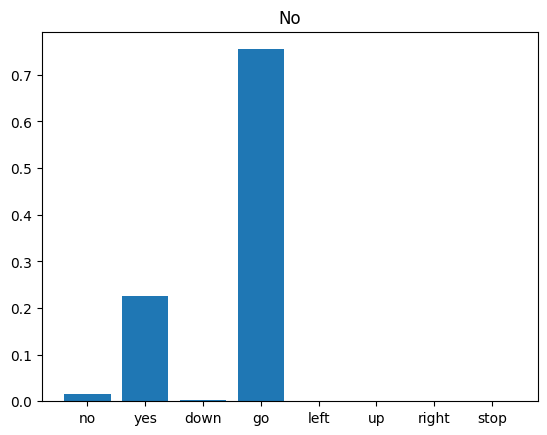

In [ ]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [ ]:
# Tähän tehdään neuroverkon viimeinen laskenta toka dense_1 layerille

def dense2(a0,w1,b1):
  a1 = np.matmul(a0,w1) + b1
  #a1 = np.matmul(w1,a0) + b1
  return a1



'\n#testattaessa käytin joskus tätä koodia\nw1 = np.load(\'tokaDenseWeights.npy\')\nprint(w1.shape)\nb1 = np.load(\'tokaDenseBiases.npy\')\nprint(b1.shape)\na0 = np.zeros(128)\na1 = dense2(a0,w1,b1)\nprint("shape of a1 = ", a1.shape)\nprint(a1)\n'

<Sequential name=sequential_62, built=True>
<Dense name=dense_1, built=True>
<Sequential name=sequential_63, built=True>
[(128, 8), (8,)]
w1 =  [[-0.04379078 -0.1368129   0.16875696 ... -0.07679154 -0.17427781
  -0.18150963]
 [ 0.105463   -0.00790655  0.15037137 ... -0.12505092 -0.06451558
  -0.06070771]
 [ 0.11771376  0.0991668  -0.0982122  ...  0.12109423 -0.08947841
  -0.12706652]
 ...
 [-0.25272775  0.13877892  0.16197076 ... -0.16279668  0.10690974
  -0.28584665]
 [ 0.18939513  0.0710382  -0.18019375 ... -0.08196097  0.01206197
   0.02211859]
 [-0.15278216  0.10241892  0.19493836 ...  0.1938659   0.20779674
  -0.00438307]]
w1 shape =  (128, 8)
b1 =  [ 0.0499085  -0.00152918 -0.01626551  0.03188952 -0.0569833  -0.03285292
  0.04682542 -0.04918874]
b1 shape =  (8,)
oma tulos =  [[ 0.42350638  3.1451063  -1.4512968   4.3498764  -2.8928323  -3.3786447
  -3.3858578  -2.708814  ]]


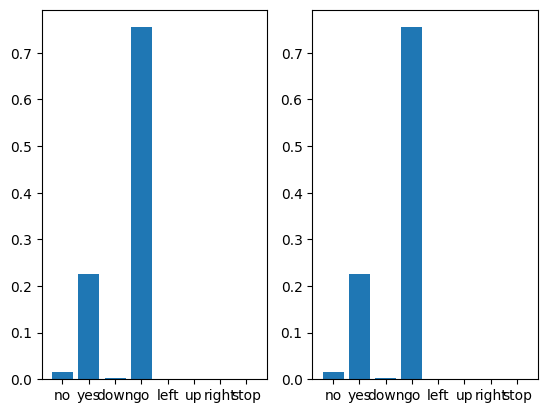

In [ ]:
'''
Homma kannattaisi aloittaa verkon loppupäästä

'''

(start, layer, end) = get_reference_layer("dense_1", model)
print(start)
print(layer)
print(end)
#print(get_layer_weights("dense_1",model))
print(get_weights_shape(get_layer_weights("dense_1",model)))
weights = get_layer_weights("dense_1",model)

#print("Original input", model.input_shape)
#print("Start input", start.input_shape)
#print("Layer input", layer.input.shape)
#print("End input", end.input_shape)

# To use the model parts, call the part with the input data
result = start(x)             # tämä antaa siis verkon oikean tuloksen ennen viimeistä dense_1
                              # layeriä
layer_result = layer(result)  # Ja tämä tuloksen dense_1:n jälkeen
a0 = result                   # viimeiseen neuroverkon kerrokseen menevät 128 neuronia inputtina
w1 = weights[0]
print("w1 = ", w1)
print("w1 shape = ", w1.shape)
b1 = weights[1]
print("b1 = ", b1)
print("b1 shape = ", b1.shape)
layer_oma_result = dense2(a0,w1,b1)
print("oma tulos = ",layer_oma_result)

#print(layer_result)
#print(layer_result.shape)
#print(layer_result[0,:])
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.figure(1)
plt.subplot(1,2,1)
plt.bar(x_labels, tf.nn.softmax(layer_result[0,:]))
plt.subplot(1,2,2)
plt.bar(x_labels, tf.nn.softmax(layer_oma_result[0,:]))
#plt.title('No')
plt.show()
